In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd 
from torch.utils.data import DataLoader ,Dataset
import numpy as np 
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt





In [99]:
# Load your data
X = pd.read_csv("../Data/One_study2.csv", sep=",") # This should be the matrix of microbiome data
#X= pd.DataFrame(X)
y = X[["Sample", "Case"]] # This should be the binary variable indicating healthy/diseased
X.drop(X[["Sample", "Case"]], axis=1, inplace=True)
X = X.applymap(lambda x: 1 if x == 'Healthy' else x)






In [100]:
X.shape

(277, 294)

In [101]:
# Extract the feature columns and label column
features = X.values
label = y['Case'].replace({"Healthy": 1, "Diseased": 0})


# Convert each element of the array to a float
features = features.astype(float)

# Convert the labels to numerical values
#label_dict = {'Healthy': 1, 'Diseased': 0}
#label_n = [label_dict[label] for label in label]

# Convert the feature columns to a PyTorch tensor
features_tensor = torch.tensor(features)

# Convert the label column to a PyTorch tensor
label_tensor = torch.tensor(label)

# Create a TensorDataset from the feature and label tensors
dataset = torch.utils.data.TensorDataset(features_tensor, label_tensor)

#Save it to tensor .pt objects
torch.save(label_tensor, '../Data/labels.pt')
torch.save(features_tensor, '../Data/features.pt')



In [102]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim
        
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        
        # Decoder
        self.fc3 = nn.Linear(z_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        h1 = nn.functional.relu(self.fc1(x))
        mu, logvar = self.fc21(h1), self.fc22(h1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h3 = nn.functional.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.double().input_dim).double())
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [103]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 294), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [104]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [105]:
def train_vae1(model, eex, epochs, batch_size, learning_rate):
    train_loader =  DataLoader(dataset, batch_size=20, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for batch_idx, eex in enumerate(train_loader):
           
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
        print('Epoch: {} \t Loss: {:.6f}'.format(epoch+1, train_loss / len(train_loader.dataset)))

In [153]:
input_dim = 294 # Define the size of your input data
my_list = 20
z_dim = 2 # Define the size of the latent space
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(input_dim,my_list, z_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 50

In [296]:
# Load the microbiome data and labels into PyTorch tensors
data = torch.load("../Data/features.pt")
labels = torch.load("../Data/labels.pt")
nan_indices = torch.isnan(data)
data = torch.where(nan_indices, torch.tensor(0.0), data)


dataset = torch.utils.data.TensorDataset(data, labels)
# Define the dataset and dataloader
dataloader = DataLoader(dataset, batch_size=50)

In [ ]:
train_vae1(model, dataloader, 200, 32, 1e-4)

In [161]:
torch.save(VAE.state_dict(model), '../Model/vae_one_study2.pth')

In [162]:
#load Model and encode data
VAE.load_state_dict(model, torch.load('vae_one_study2.pth'))


<All keys matched successfully>

In [280]:
with torch.no_grad():
    z, _ = model.encode(data)

In [113]:
# Import dataset and classes needed in this example:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from itertools import product

# Import Gaussian Naive Bayes classifier:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


In [301]:
# Split dataset into random train and test subsets:
train, test, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=5)

# Initialize classifier:
gnb = GaussianNB()

# Train the classifier:
classifier = gnb.fit(train, train_labels)
# Make predictions with the classifier:
predictive_labels = gnb.predict(test)
print(predictive_labels)

# Evaluate label (subsets) accuracy:
print(accuracy_score(test_labels, predictive_labels))

[1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 1
 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0]
0.5357142857142857


In [288]:
# Split dataset into random train and test subsets:
train, test, train_labels, test_labels = train_test_split(z, labels, test_size=0.2, random_state=11)

# Initialize classifier:
gnb = GaussianNB()

# Train the classifier:
classifier = gnb.fit(train, train_labels)
# Make predictions with the classifier:
predictive_labels = gnb.predict(test)
print(predictive_labels)

# Evaluate label (subsets) accuracy:
print(accuracy_score(test_labels, predictive_labels))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.4642857142857143


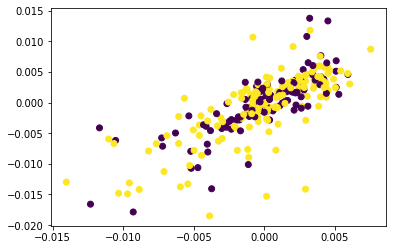

In [295]:
plt.scatter(z[:, 0], z[:, 1],c= labels)


In [230]:
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(z, labels)
# Evaluate the classifier on the validation set
y_val_pred = clf.predict(test)
val_accuracy = accuracy_score(test_labels, y_val_pred)
val_confusion_matrix = confusion_matrix(test_labels, y_val_pred)

In [231]:
print(f"Validation accuracy: {val_accuracy:.4f}")
print(f"Validation confusion matrix:\n{val_confusion_matrix}")

Validation accuracy: 0.4643
Validation confusion matrix:
[[ 0 30]
 [ 0 26]]


In [121]:
# Plot the decision boundaries and data points
x_min, x_max = test.min() - 0.1, test.max() + 0.1
y_min, y_max = test.min() - 0.1, test.max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))


In [241]:
from sklearn.svm import SVC

def classify_data_SVC(z):
    # Initialize the group labels randomly
    labels = np.random.randint(0, 2, size=z.shape[0])

    # Loop until the groups stabilize
    while True:
        # Train an SVM classifier with a non-linear kernel on the latent space coordinates and the group labels
        clf = SVC(kernel='rbf').fit(z, labels)

        # Predict the group labels for all data points
        pred_labels = clf.predict(z)

        # Check if the predicted labels match the current labels
        if np.array_equal(pred_labels, labels):
            break

        # If not, update the group labels
        labels = pred_labels

    # Return the final group labels
    return labels

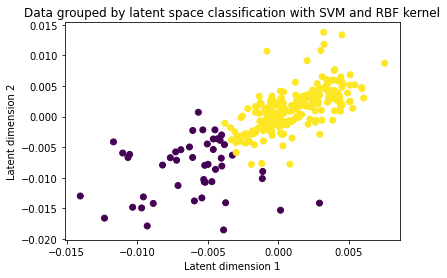

In [291]:
labels = classify_data_SVC(z)

# Create a scatter plot of the latent space coordinates, color-coded by group
plt.scatter(z[:, 0], z[:, 1], c=labels)

# Add axis labels and a title
plt.xlabel('Latent dimension 1')
plt.ylabel('Latent dimension 2')
plt.title('Data grouped by latent space classification with SVM and RBF kernel')



# Show the plot
plt.show()

In [239]:

def classify_data_GNB(z):
    # Initialize the group labels randomly
    labels = np.random.randint(0, 2, size=z.shape[0])

    # Loop until the groups stabilize
    while True:
        # Train an SVM classifier with a non-linear kernel on the latent space coordinates and the group labels
        # Initialize classifier:
        clf = GaussianNB()

        # Train the classifier:     
        pred_labels =clf.fit(z,labels)
        
        # Make predictions with the classifier:
        pred_labels = gnb.predict(labels)

        # Check if the predicted labels match the current labels
        if np.array_equal(pred_labels, labels):
            break

        # If not, update the group labels
        labels = pred_labels

    # Return the final group labels
    return labels

In [ ]:
labels = classify_data_GNB(z)

# Create a scatter plot of the latent space coordinates, color-coded by group
plt.scatter(z[:, 0], z[:, 1], c=labels)

# Add axis labels and a title
plt.xlabel('Latent dimension 1')
plt.ylabel('Latent dimension 2')
plt.title('Data grouped by latent space classification with SVM and RBF kernel')



# Show the plot
plt.show()

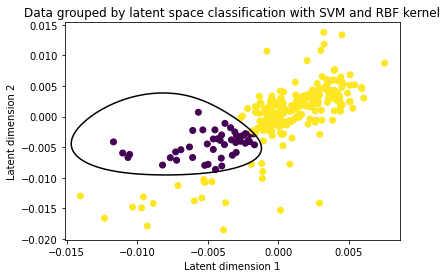

In [229]:
def classify_data(z):
    # Initialize the group labels randomly
    labels = np.random.randint(0, 2, size=z.shape[0])

    # Loop until the groups stabilize
    while True:
        # Train an SVM classifier with a non-linear kernel on the latent space coordinates and the group labels
        clf = SVC(kernel='rbf').fit(z, labels)

        # Predict the group labels for all data points
        pred_labels = clf.predict(z)

        # Check if the predicted labels match the current labels
        if np.array_equal(pred_labels, labels):
            break

        # If not, update the group labels
        labels = pred_labels

    # Return the final group labels and the trained classifier
    return labels, clf

# Generate the group labels and the trained classifier using the classify_data function with SVM and RBF kernel
labels, clf = classify_data(z)

# Create a scatter plot of the latent space coordinates, color-coded by group
plt.scatter(z[:, 0], z[:, 1], c=labels)

# Add axis labels and a title
plt.xlabel('Latent dimension 1')
plt.ylabel('Latent dimension 2')
plt.title('Data grouped by latent space classification with SVM and RBF kernel')

# Add the decision boundaries to the plot
xlim = plt.xlim()
ylim = plt.ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=100), np.linspace(*ylim, num=100))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[0], linestyles=['-'])

# Show the plot
plt.show()